In [2]:
import numpy as np
import matplotlib.pyplot as plt
from diffractio.scalar_sources_X import Scalar_source_X

%matplotlib ipympl

In [3]:
def get_pixel_coords(
    rays_x, rays_y, shape, pixel_size
):

    transform = np.eye(2)

    y_transformed, x_transformed = (np.array((rays_y, rays_x)).T @ transform).T

    sy, sx = shape
    pixel_coords_x = (x_transformed / pixel_size) + (sx // 2)
    pixel_coords_y = (y_transformed / pixel_size) + (sy // 2)

    return (pixel_coords_x, pixel_coords_y)

ds= 1.01e-06 dn = 1 p = 1e-07


/tmp/ipykernel_2664255/2589660713.py:61: RuntimeWarning: invalid value encountered in sqrt
  wi = np.sqrt(1 / np.dot(ray_source_aper.T, aperture_norm))


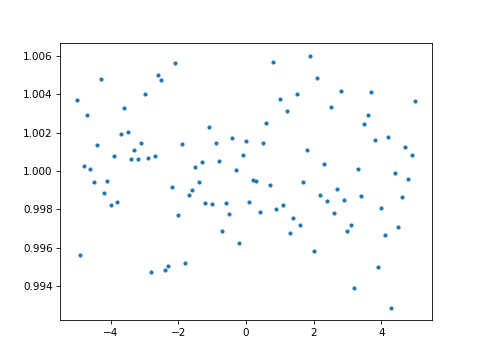

In [4]:
import matplotlib.pyplot as plt
import numpy as np

z_source = 1500.0
z_aper = 1000.0
z_det = 0.0

z_prop = z_aper - z_det

# Given data for the setup
num_px_source_x = int(1e7)
num_px_source_y = 1
num_px_det_x = 100
num_px_det_y = 1
num_px_aper_x = 101
num_px_aper_y = 1

det_px_width_x = 0.01
aper_px_width_x = 0.1

aper_width = aper_px_width_x * num_px_aper_x

source_px_width_x = aper_width / num_px_source_x

source_x_coords = np.linspace(0 - (num_px_source_x  - 1) * source_px_width_x/2, 0 + (num_px_source_x - 1) * source_px_width_x/2, num_px_source_x)
source_x_edges = np.linspace(0 - (num_px_source_x) * source_px_width_x/2, 0 + (num_px_source_x) * source_px_width_x/2, num_px_source_x + 1)
detector_x_coords = np.linspace(0 - (num_px_det_x - 1) * det_px_width_x/2, 0 + (num_px_det_x - 1) * det_px_width_x/2, num_px_det_x)
detector_x_edges = np.linspace(0 - (num_px_det_x) * det_px_width_x/2, 0 + (num_px_det_x) * det_px_width_x/2, num_px_det_x + 1)
aperture_x_coords = np.linspace(0 - (num_px_aper_x - 1) * aper_px_width_x/2, 0 + (num_px_aper_x - 1) * aper_px_width_x/2, num_px_aper_x)
aperture_x_edges = np.linspace(0 - (num_px_aper_x) * aper_px_width_x/2, 0 + (num_px_aper_x) * aper_px_width_x/2, num_px_aper_x + 1)

aperture_norm = np.array([1, 0])
N = num_px_source_x# number of rays
ray_source_x = np.random.uniform(aperture_x_edges[0], aperture_x_edges[-1], N)
ray_source_z = np.ones(N) * z_source

ray_aper_x = ray_source_x
ray_aper_z = np.ones(N) * z_aper 

# Convert coordinates to a vector for convenience
ray_source_coord = np.array([ray_source_z, ray_source_x])   
ray_aper_coord = np.array([ray_aper_z, ray_aper_x])

# Create ray vector and get magnitude and direction
ray_source_aper = ray_aper_coord - ray_source_coord
ray_source_aper_magnitude = np.linalg.norm(ray_source_aper, axis = 0)
ray_source_aper_direction = ray_source_aper  / ray_source_aper_magnitude

min_theta = np.arcsin(z_prop/np.sqrt((aperture_x_edges[0] - detector_x_edges[0])**2 + z_prop ** 2))
max_theta = np.arcsin(z_prop/np.sqrt((aperture_x_edges[-1] - detector_x_edges[-1])**2 + z_prop ** 2))

amplitude = 1.0

dn = 1
ds = source_px_width_x
p = dn / (ds * N)

print('ds=', ds, 'dn =', dn, 'p =', p * ds)
ws = np.sqrt(1 / p)
wp = np.sqrt(1 / p)
wi = np.sqrt(1 / np.dot(ray_source_aper.T, aperture_norm))

ray_amplitude = np.ones(N) * amplitude * ws * wp
aper_image_real = np.zeros((num_px_aper_y, num_px_aper_x))

pixel_coords_x, pixel_coords_y = get_pixel_coords(ray_source_x, np.zeros(ray_source_x.shape), aper_image_real.shape, aper_px_width_x)
pixel_coords_y, pixel_coords_x = np.round((pixel_coords_y, pixel_coords_x)).astype(int)

sy, sx = aper_image_real.shape

mask = np.logical_and(
    np.logical_and(
        0 <= pixel_coords_y,
        pixel_coords_y < sy
    ),
    np.logical_and(
        0 <= pixel_coords_x,
        pixel_coords_x < sx
    )
)

flat_icds = np.ravel_multi_index(
    [
        pixel_coords_y[mask],
        pixel_coords_x[mask],
    ],
    aper_image_real.shape
)

np.add.at(
    aper_image_real.ravel(),
    flat_icds,
    ray_amplitude,
)

aper_image_real *= 1 / (N * aper_px_width_x)

plt.figure()
plt.plot(aperture_x_coords, aper_image_real[0, :], '.')



By the central limit theorem, 

$\langle w(\boldsymbol{X})\rangle=\iint w(\boldsymbol{x}) p(\boldsymbol{x}) d^2 \boldsymbol{x}$

if the correct weights and probability function to approximate a part of a quantity can be chosen, and enough of those values can be added together,
then they will eventually converge on the expected value of that quantity. The challenge in monte carlo ray tracing is to choose the correct weights and probability function so that individual rays can be used to approximate the intensity of a wavefront. 

$$
p(\boldsymbol{x})=\lim _{\Delta S \rightarrow 0, N \rightarrow \infty} \frac{\Delta N(\boldsymbol{x}, N)}{\Delta S(\boldsymbol{x}) N},
$$

$$
w_I(\boldsymbol{x})=\frac{I(\boldsymbol{x})}{p(\boldsymbol{x})},
$$

p and w are given by the following functions, and using the intensity law of geometrical optics states that 

$ I_{0} \delta S_{0} = I_{1} \delta S_{1}  $

We can derive a relation to calculate the weight at $$w_I$$ 



In [5]:
ray_det_x = np.random.uniform(detector_x_edges[0], detector_x_edges[-1], N)
ray_det_z = np.ones(N) * z_det

ray_det_coord = np.array([ray_det_z, ray_det_x])

ray_aper_det = ray_det_coord - ray_aper_coord
ray_aper_det_magnitude = np.linalg.norm(ray_aper_det, axis = 0)
ray_aper_det_direction = ray_aper_det / ray_aper_det_magnitude

ray_angle = np.tan(ray_aper_det_direction[1, :] / ray_aper_det_direction[0, :])

det_image_real = np.zeros((num_px_det_y, num_px_det_x))
 
pixel_coords_x, pixel_coords_y = get_pixel_coords(ray_det_x, np.zeros(ray_det_x.shape), (det_image_real.shape), det_px_width_x)
pixel_coords_y, pixel_coords_x = np.floor((pixel_coords_y, pixel_coords_x)).astype(int)

sy, sx = det_image_real.shape

mask = np.logical_and(
    np.logical_and(
        0 <= pixel_coords_y,
        pixel_coords_y < sy
    ),
    np.logical_and(
        0 <= pixel_coords_x,
        pixel_coords_x < sx
    )
)

flat_icds = np.ravel_multi_index(
    [
        pixel_coords_y[mask],
        pixel_coords_x[mask],
    ],
 det_image_real.shape
)

dn0 = 1
ds0 = source_px_width_x
p0 = dn0 / (ds0 * N)
ws0 = np.sqrt(1 / p0)

dn1 = 1
ds1 = np.abs(np.sin(ray_angle)) / (ray_aper_det_magnitude ** 2)
p1 = dn1 / (ds1 * N)

ws1 = np.sqrt(1 / p1)
wi = np.sqrt(1 / np.abs(np.dot(ray_aper_det_direction.T, aperture_norm)))


ray_amplitude = np.ones(N) * amplitude * ws0 * ws1

np.add.at(
 det_image_real.ravel(),
    flat_icds,
    ray_amplitude,
)
det_image_real *= 1 / (N * det_px_width_x)




Good result: factor 1761.76


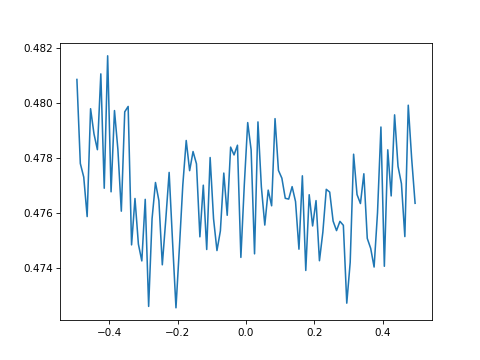

In [6]:
plt.figure()
plt.plot(detector_x_coords, det_image_real[0, :])

# Make scalar source
u0 = Scalar_source_X(detector_x_coords, wavelength=0.638)
u0.spherical_wave(A=1, x0=0, z0=0, normalize=True)
z = z_prop
u1 = u0.RS(z=z, new_field=True)

# plt.plot(detector_x_coords, np.abs(u1.u), '-r', label='Diffraction RayLeigh Sommerfeld')


In [7]:
detector_x_coords


array([-0.495, -0.485, -0.475, -0.465, -0.455, -0.445, -0.435, -0.425,
       -0.415, -0.405, -0.395, -0.385, -0.375, -0.365, -0.355, -0.345,
       -0.335, -0.325, -0.315, -0.305, -0.295, -0.285, -0.275, -0.265,
       -0.255, -0.245, -0.235, -0.225, -0.215, -0.205, -0.195, -0.185,
       -0.175, -0.165, -0.155, -0.145, -0.135, -0.125, -0.115, -0.105,
       -0.095, -0.085, -0.075, -0.065, -0.055, -0.045, -0.035, -0.025,
       -0.015, -0.005,  0.005,  0.015,  0.025,  0.035,  0.045,  0.055,
        0.065,  0.075,  0.085,  0.095,  0.105,  0.115,  0.125,  0.135,
        0.145,  0.155,  0.165,  0.175,  0.185,  0.195,  0.205,  0.215,
        0.225,  0.235,  0.245,  0.255,  0.265,  0.275,  0.285,  0.295,
        0.305,  0.315,  0.325,  0.335,  0.345,  0.355,  0.365,  0.375,
        0.385,  0.395,  0.405,  0.415,  0.425,  0.435,  0.445,  0.455,
        0.465,  0.475,  0.485,  0.495])

In [8]:
# # Plotting the detector pixels
# plt.figure(figsize=(12, 5))
# plt.plot(detector_x_coords, np.zeros_like(detector_x_coords), 'ro', label='Detector Pixels')
# plt.vlines(detector_x_edges, -0.05, 0.05, colors='blue')

# # Plotting the aperture pixels
# plt.plot(aperture_x_coords, np.ones_like(aperture_x_coords) * 1.0, 'ro', label='Aperture Pixels')
# plt.vlines(aperture_x_edges, 1.0-0.05, 1.0+0.05, colors='blue')

# # Plot ray vectors from source to aperture using quiver
# plt.quiver(ray_source_coord[1, :], ray_source_coord[0, :], ray_source_aper[1, :], ray_source_aper[0, :], 
#            angles='xy', scale_units='xy', scale=1, color='k')

# plt.quiver(ray_aper_coord[1, :], ray_aper_coord[0, :], ray_aper_det[1, :], ray_aper_det[0, :], 
#            angles='xy', scale_units='xy', scale=1, color='k')


# # Setting up plot aesthetics
# plt.legend()
# plt.xlabel('Pixel Position')
# plt.yticks([0, 1.0], ['Detector', 'Aperture'])
# plt.title('Aperture and Detector Pixel Arrangement')
# plt.grid(True)
# # plt.axis('equal')
# plt.show()

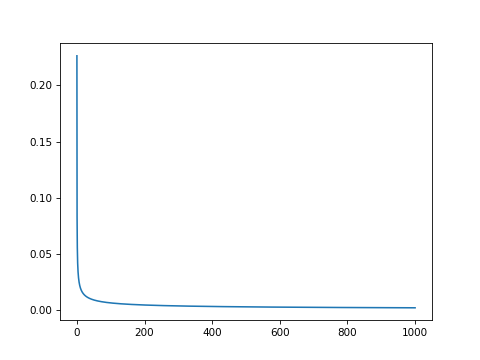